In [38]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor
import colorsys
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# import lightgbm as lgbm
import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
pd.set_option('display.max_Columns', 100)
warnings.simplefilter('ignore', UserWarning)

In [2]:
color = pd.read_csv('../input/color.csv')
color_rgb = pd.DataFrame(color['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                         columns=['color_r', 'color_g', 'color_b'])
color = pd.concat([color, color_rgb], axis=1)
color['ratio'] = color['percentage']/100
print('color', color.shape)

color (73636, 7)


In [3]:
palette = pd.read_csv('../input/palette.csv')
print('palette', palette.shape)
material = pd.read_csv('../input/material.csv')
print('material', material.shape)
object_collection = pd.read_csv('../input/object_collection.csv')
print('object_collection', object_collection.shape)
technique = pd.read_csv('../input/technique.csv')
print('technique', technique.shape)
production_place = pd.read_csv('../input/production_place.csv')
print('production_place', production_place.shape)
production_country = pd.read_csv('../input/production_country.csv')
print('production_country', production_country.shape)
historical_person = pd.read_csv('../input/historical_person.csv')
print('historical_person', historical_person.shape)
maker = pd.read_csv('../input/maker.csv')
print('maker', maker.shape)
principal_maker = pd.read_csv('../input/principal_maker.csv')
print('principal_maker', principal_maker.shape)
principal_maker_occupation = pd.read_csv('../input/principal_maker_occupation.csv')
print('principal_maker_occupation', principal_maker_occupation.shape)
train = pd.read_csv('../input/train.csv')
print('train', train.shape)
test = pd.read_csv('../input/test.csv')
print('test', test.shape)
whole = pd.concat([train, test])
print('whole', whole.shape)

palette (527890, 5)
material (35394, 2)
object_collection (14210, 2)
technique (20481, 2)
production_place (17686, 2)
production_country (17686, 2)
historical_person (6745, 2)
maker (3291, 6)
principal_maker (24538, 6)
principal_maker_occupation (25372, 2)
train (12026, 19)
test (12008, 18)
whole (24034, 19)


### Color

In [5]:
def rgb_to_h(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[0]

def rgb_to_s(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[1]

def rgb_to_v(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[2]

def get_total_color(color_input):
    cp = color_input.copy()
    cp['R'] = cp['color_r']*cp['ratio']/255
    cp['G'] = cp['color_g']*cp['ratio']/255
    cp['B'] = cp['color_b']*cp['ratio']/255
    rgb = cp.groupby('object_id').sum()[['R','G','B']]
    rgb['H'] = rgb.apply(rgb_to_h, axis=1)
    rgb['S'] = rgb.apply(rgb_to_s, axis=1)
    rgb['V'] = rgb.apply(rgb_to_v, axis=1)
    return rgb

main_color = get_total_color(color).add_prefix('color_').reset_index()
main_palette = get_total_color(palette).add_prefix('plt_').reset_index()

In [6]:
def create_main_color_feature(df_input):
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, main_color, on='object_id', how='left')
    cp = pd.merge(cp, main_palette, on='object_id', how='left')
    cp = cp.fillna(0).drop(columns=['object_id'])
    cp.index = df_input.index
    return cp

In [7]:
def get_color_count(df_input, color_input, col):
    color_cp = color_input[color_input['ratio'] > 0.05].copy()
    group = color_cp.groupby('object_id').size().rename(col).reset_index()
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, group, on='object_id', how='left').fillna(0)
    return cp[[col]]

def create_color_count_feature(df_input):
    color_count = get_color_count(df_input, color, 'color_count')
    color_count.index = df_input.index
    palette_count = get_color_count(df_input, palette, 'palette_count')
    palette_count.index = df_input.index
    return pd.concat([color_count, palette_count], axis=1)

In [8]:
def create_numeric_feature(df_input):
    cp = df_input.copy()
    cp['acquisition_year'] = pd.to_datetime(df_input['acquisition_date']).dt.year
    return cp[['acquisition_year', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late']]

#### Count encoding

In [9]:
def create_count_encoding_feature_sub(df_whole, df_input, column):
    cp = df_input.copy()
    newcol = 'CE_'+column
    group = df_whole.groupby(column).size().rename(newcol)
    group = pd.DataFrame(group).reset_index()
    cp = pd.merge(cp, group, on=column, how='left')
    cp = cp[[newcol]].fillna(0)
    cp.index = df_input.index
    return cp

def create_count_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method', 'dating_sorting_date']
    cp = df_input.copy()
    len_cp = len(cp)
    org_col = cp.columns
    for col in col_list:
        tmp = create_count_encoding_feature_sub(whole, cp, col)
        cp = pd.concat([cp, tmp], axis=1)
        assert len(cp) == len_cp
    return cp.drop(columns=org_col)

#### Label encoding

In [10]:
def create_label_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method']
    out_df = pd.DataFrame(index=df_input.index)
    le = LabelEncoder()
    for col in col_list:
        le.fit(whole[col])
        out_df[col] = le.transform(df_input[col])
    return out_df.add_prefix('LE_')

#### One-hot encoding

In [11]:
def get_one_hot_encoding(df_input, df_merge, count, prefix):
    value_counts = df_merge['name'].value_counts()
    col_list = list(value_counts.index[0:count])
    dummy = pd.get_dummies(df_merge['name'])[col_list]
    dummy = pd.concat([df_merge, dummy], axis=1)
    group = dummy.groupby('object_id').sum()
    group = group.add_prefix(prefix).reset_index()
    out = pd.merge(df_input[['object_id']], group, on='object_id', how='left')
    out = out.fillna(0).drop(columns=['object_id'])
    out.index = df_input.index
    return out

def creat_material_feature(df_input):
    return get_one_hot_encoding(df_input, material, 10, 'MT_')

def creat_object_collection_feature(df_input):
    return get_one_hot_encoding(df_input, object_collection, 3, 'OC_')

def creat_production_place_feature(df_input):
    return get_one_hot_encoding(df_input, production_place, 10, 'PP_')

def creat_production_country_feature(df_input):
    return get_one_hot_encoding(df_input, production_country, 17, 'PC_')

def creat_technique_feature(df_input):
    return get_one_hot_encoding(df_input, technique, 10, 'TC_')

def creat_historical_person_feature(df_input):
    ohe = get_one_hot_encoding(df_input, historical_person, 3, 'HP_')
    ohe.columns = ['HP_' + str(i) for i in range(len(ohe.columns))]
    return ohe

In [12]:
def create_string_length_feature(df_input):
    out_df = pd.DataFrame()
    str_columns = ['title', 'long_title', 'sub_title', 'more_title', 'description']
    for c in str_columns:
        out_df[c] = df_input[c].str.len()
    return out_df.add_prefix('LN_')

In [13]:
def create_sub_title_feature(df_input):
    out = pd.DataFrame(index=df_input.index)
    out['dimension'] = 0
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = df_input['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float)
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
        out[column_name] = size_info[column_name]
        out['dimension'] += out[column_name].apply(lambda x: 0 if np.isnan(x) else 1)
    out['area'] = out['size_h'] * out['size_w']
    return out

In [14]:
def target_encoding(df_input, target_col, k_fold=5):
    encoding_col = 'TE_' + target_col
    X = df_input
    out = pd.DataFrame(index=X.index)
    out[encoding_col] = np.NaN

    if 'likes' in df_input.columns:
        # train
        cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
        for train_index, valid_index in cv.split(X):
            x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
            likes = x_train.groupby(target_col)[['likes']].mean().reset_index()
            tmp = pd.merge(x_valid[[target_col]], likes, on=[target_col], how='left')
            tmp.index = valid_index
            out.loc[valid_index, encoding_col] = tmp['likes'].apply(np.log1p)
    else:
        # test
        likes = train.groupby(target_col)[['likes']].mean().reset_index()
        tmp = pd.merge(X[[target_col]], likes, on=[target_col], how='left')
        out[encoding_col] = tmp['likes'].apply(np.log1p)
    return out

def creat_target_encoding_principal_maker(df_input):
    return target_encoding(df_input, 'principal_maker')

def creat_target_encoding_principal_or_first_maker(df_input):
    return target_encoding(df_input, 'principal_or_first_maker')

In [15]:
func_list = [
    create_numeric_feature,
    create_count_encoding_feature,
    create_label_encoding_feature,
    create_string_length_feature,
    create_sub_title_feature,
    creat_material_feature,
    creat_object_collection_feature,
    creat_production_place_feature,
    creat_production_country_feature,
    creat_technique_feature,
    creat_historical_person_feature,
    create_main_color_feature,
    create_color_count_feature,
]

func_list_w_te = func_list + [
    creat_target_encoding_principal_maker,
    creat_target_encoding_principal_or_first_maker,
]

In [16]:
def create_all_feature(df_input, func_list):
    out = pd.DataFrame(index=df_input.index)
    for func in func_list:
        out = pd.concat([out, func(df_input)], axis=1)
        assert len(df_input) == len(out)
    return out

In [17]:
def split_train_target(df_input):
    target = df_input[['likes']].copy()
    target['target'] = target['likes'].apply(np.log1p)
    return target['target']

In [45]:
LGBM_PARAM = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
#     'max_depth' : 6,
    'verbosity': -1
}
KFOLD = 5

In [19]:
cat_feat = [
    'LE_art_series_id', 
    'LE_copyright_holder', 'LE_acquisition_method'
]

cat_feat_te = [
    'LE_principal_maker', 'LE_principal_or_first_maker', 
]

cat_feat_w_te = cat_feat + cat_feat_te

In [20]:
def get_stratified(y):
    y_bin = y.astype(int)
    y_bin[y_bin >=8] = 8
    return y_bin

In [21]:
#get_stratified(train_y1).value_counts()

In [46]:
def train_kfold(X, y, cat_feat, params=LGBM_PARAM, k_fold=KFOLD):
    rmse_list = []
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=0)
    cv_split = cv.split(X, get_stratified(y))
    
#     cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
#     cv_split = cv.split(X)

    for train_index, valid_index in cv_split:

        x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        lgbm_model = lgbm.train(params, 
                                                lgbm_train, 
                                                valid_sets=lgbm_eval,
                                                num_boost_round=10000,
                                                early_stopping_rounds=100,
                                                categorical_feature = cat_feat,
                                                verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        oof_pred[valid_index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        rmse_list.append(rmse)
        models.append(lgbm_model)

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('- TRAIN RMSE={:.4f}'.format(score))

    return models, oof_pred, score

In [23]:
def predict_test(test_X, models):
    pred_list = []
    for model in models:
        pred = model.predict(test_X, num_iteration = model.best_iteration)
        pred_list.append(pred)
    pred_test = np.mean(pred_list, axis=0)
    return pred_test

In [24]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [47]:
train_X1 = create_all_feature(train, func_list_w_te)
test_X1 = create_all_feature(test, func_list_w_te)
train_y1 = split_train_target(train)
print(train_X1.shape)
print(train_y1.shape)
print(test_X1.shape)
feat_cnt1 = len(train_X1.columns)

(12026, 96)
(12026,)
(12008, 96)


In [48]:
models1, oof_pred1, score1 = train_kfold(train_X1, train_y1, cat_feat_w_te)
pred1 = predict_test(test_X1, models1)
test_pred1 = revert_to_real(pred1)
print('test_pred1', len(test_pred1))
test_X1['likes'] = test_pred1

[I 2021-03-07 19:44:59,230] A new study created in memory with name: no-name-7776e9e4-1a08-4d67-bb17-93277245e873
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.045421:  14%|#4        | 1/7 [00:00<00:05,  1.10it/s]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.04542
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.041060:  29%|##8       | 2/7 [00:02<00:05,  1.02s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 1.04106
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.034979:  43%|####2     | 3/7 [00:03<00:04,  1.21s/it]

Early stopping, best iteration is:
[230]	valid_0's rmse: 1.03498
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.034979:  57%|#####7    | 4/7 [00:04<00:03,  1.33s/it]

Early stopping, best iteration is:
[307]	valid_0's rmse: 1.04198
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.034979:  71%|#######1  | 5/7 [00:05<00:02,  1.20s/it]

Early stopping, best iteration is:
[82]	valid_0's rmse: 1.03972
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.034574:  86%|########5 | 6/7 [00:07<00:01,  1.32s/it]

Early stopping, best iteration is:
[148]	valid_0's rmse: 1.03457
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.03129
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:   5%|5         | 1/20 [00:02<00:49,  2.63s/it]

Early stopping, best iteration is:
[27]	valid_0's rmse: 1.04467
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  10%|#         | 2/20 [00:05<00:54,  3.03s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 1.03276
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  15%|#5        | 3/20 [00:08<00:49,  2.93s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 1.03768
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  20%|##        | 4/20 [00:12<00:49,  3.11s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.03749
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  25%|##5       | 5/20 [00:15<00:47,  3.15s/it]

Early stopping, best iteration is:
[50]	valid_0's rmse: 1.03837
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  30%|###       | 6/20 [00:18<00:45,  3.23s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 1.03346
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  35%|###5      | 7/20 [00:20<00:36,  2.84s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04479
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  40%|####      | 8/20 [00:22<00:28,  2.35s/it]

Early stopping, best iteration is:
[83]	valid_0's rmse: 1.03933
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  45%|####5     | 9/20 [00:24<00:27,  2.50s/it]

Early stopping, best iteration is:
[30]	valid_0's rmse: 1.04425
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  50%|#####     | 10/20 [00:26<00:21,  2.15s/it]

Early stopping, best iteration is:
[222]	valid_0's rmse: 1.03358
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  55%|#####5    | 11/20 [00:30<00:24,  2.74s/it]

Early stopping, best iteration is:
[33]	valid_0's rmse: 1.04291
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  60%|######    | 12/20 [00:32<00:21,  2.68s/it]

Early stopping, best iteration is:
[50]	valid_0's rmse: 1.03609
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  65%|######5   | 13/20 [00:34<00:16,  2.42s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 1.0326
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  70%|#######   | 14/20 [00:37<00:14,  2.37s/it]

Early stopping, best iteration is:
[123]	valid_0's rmse: 1.03586
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  75%|#######5  | 15/20 [00:39<00:11,  2.27s/it]

Early stopping, best iteration is:
[64]	valid_0's rmse: 1.03448
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  80%|########  | 16/20 [00:41<00:08,  2.20s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 1.03893
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  85%|########5 | 17/20 [00:46<00:09,  3.27s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.03585
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  90%|######### | 18/20 [00:49<00:06,  3.04s/it]

Early stopping, best iteration is:
[90]	valid_0's rmse: 1.04078
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031293:  95%|#########5| 19/20 [00:52<00:03,  3.08s/it]

Early stopping, best iteration is:
[40]	valid_0's rmse: 1.0368
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[33]	valid_0's rmse: 1.04291
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  10%|#         | 1/10 [00:03<00:27,  3.02s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.05081
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  20%|##        | 2/10 [00:07<00:31,  3.96s/it]

Early stopping, best iteration is:
[195]	valid_0's rmse: 1.04072
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  30%|###       | 3/10 [00:08<00:18,  2.71s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 1.05548
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  40%|####      | 4/10 [00:10<00:12,  2.15s/it]

Early stopping, best iteration is:
[158]	valid_0's rmse: 1.03339
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  50%|#####     | 5/10 [00:12<00:10,  2.09s/it]

Early stopping, best iteration is:
[241]	valid_0's rmse: 1.06207
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  60%|######    | 6/10 [00:13<00:07,  1.81s/it]

Early stopping, best iteration is:
[130]	valid_0's rmse: 1.04778
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  70%|#######   | 7/10 [00:14<00:04,  1.66s/it]

Early stopping, best iteration is:
[131]	valid_0's rmse: 1.03931
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  80%|########  | 8/10 [00:16<00:03,  1.65s/it]

Early stopping, best iteration is:
[182]	valid_0's rmse: 1.03774
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.031293:  90%|######### | 9/10 [00:17<00:01,  1.62s/it]

Early stopping, best iteration is:
[183]	valid_0's rmse: 1.03745
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[162]	valid_0's rmse: 1.05054
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:  17%|#6        | 1/6 [00:01<00:05,  1.15s/it]

Early stopping, best iteration is:
[114]	valid_0's rmse: 1.0426
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:  33%|###3      | 2/6 [00:02<00:05,  1.33s/it]

Early stopping, best iteration is:
[224]	valid_0's rmse: 1.03298
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:  50%|#####     | 3/6 [00:03<00:03,  1.32s/it]

Early stopping, best iteration is:
[191]	valid_0's rmse: 1.03793
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:  67%|######6   | 4/6 [00:05<00:02,  1.36s/it]

Early stopping, best iteration is:
[185]	valid_0's rmse: 1.03175
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.031293:  83%|########3 | 5/6 [00:06<00:01,  1.40s/it]

Early stopping, best iteration is:
[195]	valid_0's rmse: 1.03173
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[80]	valid_0's rmse: 1.04164
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:   5%|5         | 1/20 [00:01<00:27,  1.44s/it]

Early stopping, best iteration is:
[161]	valid_0's rmse: 1.03626
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  10%|#         | 2/20 [00:03<00:27,  1.51s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.0313
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  15%|#5        | 3/20 [00:04<00:25,  1.51s/it]

Early stopping, best iteration is:
[186]	valid_0's rmse: 1.03305
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  20%|##        | 4/20 [00:06<00:24,  1.55s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.03132
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  25%|##5       | 5/20 [00:07<00:24,  1.64s/it]

Early stopping, best iteration is:
[202]	valid_0's rmse: 1.03618
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  30%|###       | 6/20 [00:09<00:22,  1.63s/it]

Early stopping, best iteration is:
[170]	valid_0's rmse: 1.03524
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  35%|###5      | 7/20 [00:11<00:21,  1.68s/it]

Early stopping, best iteration is:
[242]	valid_0's rmse: 1.03699
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  40%|####      | 8/20 [00:12<00:19,  1.64s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.03129
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  45%|####5     | 9/20 [00:14<00:18,  1.65s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.03131
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  50%|#####     | 10/20 [00:16<00:15,  1.59s/it]

Early stopping, best iteration is:
[169]	valid_0's rmse: 1.03349
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  55%|#####5    | 11/20 [00:18<00:16,  1.79s/it]

Early stopping, best iteration is:
[291]	valid_0's rmse: 1.03926
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  60%|######    | 12/20 [00:19<00:13,  1.72s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.0313
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031293:  65%|######5   | 13/20 [00:21<00:11,  1.71s/it]

Early stopping, best iteration is:
[180]	valid_0's rmse: 1.03817
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031291:  70%|#######   | 14/20 [00:23<00:09,  1.66s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.03129
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031291:  75%|#######5  | 15/20 [00:24<00:08,  1.62s/it]

Early stopping, best iteration is:
[176]	valid_0's rmse: 1.03886
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.031291:  80%|########  | 16/20 [00:26<00:06,  1.63s/it]

Early stopping, best iteration is:
[188]	valid_0's rmse: 1.0313
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.029832:  85%|########5 | 17/20 [00:27<00:04,  1.65s/it]

Early stopping, best iteration is:
[193]	valid_0's rmse: 1.02983
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.029832:  90%|######### | 18/20 [00:29<00:03,  1.64s/it]

Early stopping, best iteration is:
[167]	valid_0's rmse: 1.03474
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.029832:  95%|#########5| 19/20 [00:30<00:01,  1.56s/it]

Early stopping, best iteration is:
[142]	valid_0's rmse: 1.04362
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[125]	valid_0's rmse: 1.03903
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832:  20%|##        | 1/5 [00:01<00:07,  1.76s/it]

Early stopping, best iteration is:
[228]	valid_0's rmse: 1.04472
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832:  40%|####      | 2/5 [00:04<00:06,  2.14s/it]

Early stopping, best iteration is:
[310]	valid_0's rmse: 1.03094
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832:  60%|######    | 3/5 [00:05<00:03,  1.87s/it]

Early stopping, best iteration is:
[174]	valid_0's rmse: 1.03739
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832:  80%|########  | 4/5 [00:07<00:01,  1.79s/it]

Early stopping, best iteration is:
[189]	valid_0's rmse: 1.03801
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.029832: 100%|##########| 5/5 [00:09<00:00,  1.81s/it]
[I 2021-03-07 19:47:14,010] A new study created in memory with name: no-name-7372f78d-2eac-41e0-b6b8-bcd6c1e1cc3f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[189]	valid_0's rmse: 1.05446
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.071643:  14%|#4        | 1/7 [00:01<00:09,  1.66s/it]

Early stopping, best iteration is:
[303]	valid_0's rmse: 1.07164
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.071643:  29%|##8       | 2/7 [00:03<00:07,  1.49s/it]

Early stopping, best iteration is:
[147]	valid_0's rmse: 1.0724
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.071643:  43%|####2     | 3/7 [00:04<00:05,  1.29s/it]

Early stopping, best iteration is:
[142]	valid_0's rmse: 1.07457
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.071643:  57%|#####7    | 4/7 [00:05<00:03,  1.32s/it]

Early stopping, best iteration is:
[199]	valid_0's rmse: 1.07249
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.070360:  71%|#######1  | 5/7 [00:06<00:02,  1.28s/it]

Early stopping, best iteration is:
[146]	valid_0's rmse: 1.07036
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.066519:  86%|########5 | 6/7 [00:08<00:01,  1.59s/it]

Early stopping, best iteration is:
[388]	valid_0's rmse: 1.06652
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.066519:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[272]	valid_0's rmse: 1.07474
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.066519:   5%|5         | 1/20 [00:02<00:48,  2.55s/it]

Early stopping, best iteration is:
[49]	valid_0's rmse: 1.07534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.066519:  10%|#         | 2/20 [00:05<00:45,  2.53s/it]

Early stopping, best iteration is:
[112]	valid_0's rmse: 1.06948
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.066519:  15%|#5        | 3/20 [00:08<00:49,  2.93s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.06708
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.066066:  20%|##        | 4/20 [00:10<00:43,  2.73s/it]

Early stopping, best iteration is:
[77]	valid_0's rmse: 1.06607
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065746:  25%|##5       | 5/20 [00:14<00:44,  2.98s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 1.06575
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065746:  30%|###       | 6/20 [00:17<00:44,  3.16s/it]

Early stopping, best iteration is:
[94]	valid_0's rmse: 1.07278
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065746:  35%|###5      | 7/20 [00:21<00:42,  3.29s/it]

Early stopping, best iteration is:
[45]	valid_0's rmse: 1.07262
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065681:  40%|####      | 8/20 [00:24<00:39,  3.25s/it]

Early stopping, best iteration is:
[45]	valid_0's rmse: 1.06568
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065681:  45%|####5     | 9/20 [00:26<00:30,  2.74s/it]

Early stopping, best iteration is:
[116]	valid_0's rmse: 1.07218
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065681:  50%|#####     | 10/20 [00:29<00:28,  2.85s/it]

Early stopping, best iteration is:
[41]	valid_0's rmse: 1.07613
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  55%|#####5    | 11/20 [00:32<00:25,  2.81s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06396
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  60%|######    | 12/20 [00:33<00:19,  2.41s/it]

Early stopping, best iteration is:
[667]	valid_0's rmse: 1.07309
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  65%|######5   | 13/20 [00:35<00:15,  2.28s/it]

Early stopping, best iteration is:
[746]	valid_0's rmse: 1.06768
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  70%|#######   | 14/20 [00:37<00:12,  2.07s/it]

Early stopping, best iteration is:
[130]	valid_0's rmse: 1.06809
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  75%|#######5  | 15/20 [00:39<00:10,  2.15s/it]

Early stopping, best iteration is:
[129]	valid_0's rmse: 1.07513
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  80%|########  | 16/20 [00:40<00:07,  1.91s/it]

Early stopping, best iteration is:
[108]	valid_0's rmse: 1.07116
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  85%|########5 | 17/20 [00:43<00:06,  2.06s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 1.07634
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  90%|######### | 18/20 [00:46<00:04,  2.44s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.07105
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.063965:  95%|#########5| 19/20 [00:49<00:02,  2.71s/it]

Early stopping, best iteration is:
[39]	valid_0's rmse: 1.07716
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[118]	valid_0's rmse: 1.06491
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  10%|#         | 1/10 [00:03<00:30,  3.40s/it]

Early stopping, best iteration is:
[384]	valid_0's rmse: 1.08578
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  20%|##        | 2/10 [00:06<00:26,  3.37s/it]

Early stopping, best iteration is:
[642]	valid_0's rmse: 1.07336
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  30%|###       | 3/10 [00:08<00:17,  2.50s/it]

Early stopping, best iteration is:
[410]	valid_0's rmse: 1.07864
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  40%|####      | 4/10 [00:12<00:18,  3.16s/it]

Early stopping, best iteration is:
[554]	valid_0's rmse: 1.07518
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  50%|#####     | 5/10 [00:14<00:14,  2.93s/it]

Early stopping, best iteration is:
[581]	valid_0's rmse: 1.07887
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  60%|######    | 6/10 [00:17<00:10,  2.73s/it]

Early stopping, best iteration is:
[650]	valid_0's rmse: 1.07062
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  70%|#######   | 7/10 [00:19<00:08,  2.67s/it]

Early stopping, best iteration is:
[783]	valid_0's rmse: 1.07294
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  80%|########  | 8/10 [00:22<00:05,  2.75s/it]

Early stopping, best iteration is:
[732]	valid_0's rmse: 1.06824
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.063965:  90%|######### | 9/10 [00:24<00:02,  2.56s/it]

Early stopping, best iteration is:
[610]	valid_0's rmse: 1.08032
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[696]	valid_0's rmse: 1.08033
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:  17%|#6        | 1/6 [00:02<00:11,  2.23s/it]

Early stopping, best iteration is:
[824]	valid_0's rmse: 1.07413
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:  33%|###3      | 2/6 [00:05<00:10,  2.74s/it]

Early stopping, best iteration is:
[810]	valid_0's rmse: 1.07409
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:  50%|#####     | 3/6 [00:07<00:07,  2.42s/it]

Early stopping, best iteration is:
[802]	valid_0's rmse: 1.07461
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:  67%|######6   | 4/6 [00:10<00:05,  2.84s/it]

Early stopping, best iteration is:
[684]	valid_0's rmse: 1.07612
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.063965:  83%|########3 | 5/6 [00:12<00:02,  2.36s/it]

Early stopping, best iteration is:
[555]	valid_0's rmse: 1.08146
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[634]	valid_0's rmse: 1.07616
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:   5%|5         | 1/20 [00:01<00:35,  1.87s/it]

Early stopping, best iteration is:
[780]	valid_0's rmse: 1.07302
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  10%|#         | 2/20 [00:03<00:33,  1.84s/it]

Early stopping, best iteration is:
[761]	valid_0's rmse: 1.08027
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  15%|#5        | 3/20 [00:07<00:43,  2.55s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06402
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  20%|##        | 4/20 [00:10<00:45,  2.87s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06401
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  25%|##5       | 5/20 [00:12<00:40,  2.69s/it]

Early stopping, best iteration is:
[1006]	valid_0's rmse: 1.07001
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  30%|###       | 6/20 [00:14<00:31,  2.24s/it]

Early stopping, best iteration is:
[563]	valid_0's rmse: 1.07936
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  35%|###5      | 7/20 [00:16<00:27,  2.14s/it]

Early stopping, best iteration is:
[796]	valid_0's rmse: 1.0714
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  40%|####      | 8/20 [00:20<00:33,  2.82s/it]

Early stopping, best iteration is:
[977]	valid_0's rmse: 1.07136
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  45%|####5     | 9/20 [00:22<00:29,  2.69s/it]

Early stopping, best iteration is:
[787]	valid_0's rmse: 1.07095
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  50%|#####     | 10/20 [00:25<00:27,  2.79s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06397
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  55%|#####5    | 11/20 [00:29<00:26,  2.99s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06405
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  60%|######    | 12/20 [00:34<00:29,  3.69s/it]

Early stopping, best iteration is:
[823]	valid_0's rmse: 1.07408
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  65%|######5   | 13/20 [00:39<00:28,  4.02s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06408
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  70%|#######   | 14/20 [00:42<00:21,  3.62s/it]

Early stopping, best iteration is:
[621]	valid_0's rmse: 1.07376
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  75%|#######5  | 15/20 [00:45<00:17,  3.57s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06406
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  80%|########  | 16/20 [00:48<00:13,  3.33s/it]

Early stopping, best iteration is:
[658]	valid_0's rmse: 1.07879
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  85%|########5 | 17/20 [00:52<00:10,  3.66s/it]

Early stopping, best iteration is:
[981]	valid_0's rmse: 1.06981
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  90%|######### | 18/20 [00:56<00:07,  3.69s/it]

Early stopping, best iteration is:
[826]	valid_0's rmse: 1.07108
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.063965:  95%|#########5| 19/20 [01:00<00:03,  3.66s/it]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06403
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.06403
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965:  20%|##        | 1/5 [00:01<00:06,  1.64s/it]

Early stopping, best iteration is:
[751]	valid_0's rmse: 1.08082
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965:  40%|####      | 2/5 [00:03<00:04,  1.53s/it]

Early stopping, best iteration is:
[676]	valid_0's rmse: 1.07623
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965:  60%|######    | 3/5 [00:04<00:02,  1.27s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 1.07823
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965:  80%|########  | 4/5 [00:06<00:01,  1.53s/it]

Early stopping, best iteration is:
[767]	valid_0's rmse: 1.07518
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.063965: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]
[I 2021-03-07 19:50:12,165] A new study created in memory with name: no-name-6a938d28-a01f-436c-adcc-dfb147149228
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[858]	valid_0's rmse: 1.07532
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.048707:  14%|#4        | 1/7 [00:01<00:06,  1.07s/it]

Early stopping, best iteration is:
[165]	valid_0's rmse: 1.04871
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.046315:  29%|##8       | 2/7 [00:02<00:06,  1.21s/it]

Early stopping, best iteration is:
[194]	valid_0's rmse: 1.04632
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.046315:  43%|####2     | 3/7 [00:03<00:04,  1.23s/it]

Early stopping, best iteration is:
[127]	valid_0's rmse: 1.05008
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.042945:  57%|#####7    | 4/7 [00:05<00:03,  1.30s/it]

Early stopping, best iteration is:
[183]	valid_0's rmse: 1.04294
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.042945:  71%|#######1  | 5/7 [00:06<00:02,  1.32s/it]

Early stopping, best iteration is:
[241]	valid_0's rmse: 1.04569
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.042945:  86%|########5 | 6/7 [00:07<00:01,  1.30s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 1.05019
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.042945:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[117]	valid_0's rmse: 1.04418
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.042945:   5%|5         | 1/20 [00:03<01:10,  3.69s/it]

Early stopping, best iteration is:
[35]	valid_0's rmse: 1.05011
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.042945:  10%|#         | 2/20 [00:06<00:57,  3.17s/it]

Early stopping, best iteration is:
[176]	valid_0's rmse: 1.05856
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.042945:  15%|#5        | 3/20 [00:09<00:55,  3.28s/it]

Early stopping, best iteration is:
[38]	valid_0's rmse: 1.04758
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.042945:  20%|##        | 4/20 [00:13<00:53,  3.36s/it]

Early stopping, best iteration is:
[40]	valid_0's rmse: 1.04509
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.040951:  25%|##5       | 5/20 [00:19<01:05,  4.34s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.04095
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.040667:  30%|###       | 6/20 [00:22<00:54,  3.87s/it]

Early stopping, best iteration is:
[124]	valid_0's rmse: 1.04067
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.040667:  35%|###5      | 7/20 [00:26<00:51,  3.93s/it]

Early stopping, best iteration is:
[51]	valid_0's rmse: 1.04801
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.038685:  40%|####      | 8/20 [00:31<00:49,  4.12s/it]

Early stopping, best iteration is:
[35]	valid_0's rmse: 1.03869
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.038685:  45%|####5     | 9/20 [00:32<00:37,  3.37s/it]

Early stopping, best iteration is:
[219]	valid_0's rmse: 1.03977
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  50%|#####     | 10/20 [00:38<00:41,  4.16s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03545
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  55%|#####5    | 11/20 [00:40<00:31,  3.48s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.04539
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  60%|######    | 12/20 [00:43<00:25,  3.25s/it]

Early stopping, best iteration is:
[33]	valid_0's rmse: 1.04232
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  65%|######5   | 13/20 [00:48<00:26,  3.83s/it]

Early stopping, best iteration is:
[176]	valid_0's rmse: 1.04132
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  70%|#######   | 14/20 [00:54<00:27,  4.51s/it]

Early stopping, best iteration is:
[32]	valid_0's rmse: 1.03787
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  75%|#######5  | 15/20 [00:58<00:21,  4.37s/it]

Early stopping, best iteration is:
[37]	valid_0's rmse: 1.04259
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  80%|########  | 16/20 [01:00<00:14,  3.74s/it]

Early stopping, best iteration is:
[111]	valid_0's rmse: 1.04387
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  85%|########5 | 17/20 [01:05<00:11,  3.90s/it]

Early stopping, best iteration is:
[36]	valid_0's rmse: 1.04007
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  90%|######### | 18/20 [01:06<00:06,  3.18s/it]

Early stopping, best iteration is:
[669]	valid_0's rmse: 1.05666
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.035447:  95%|#########5| 19/20 [01:11<00:03,  3.76s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.04029
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[142]	valid_0's rmse: 1.04552
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  10%|#         | 1/10 [00:01<00:14,  1.63s/it]

Early stopping, best iteration is:
[45]	valid_0's rmse: 1.04942
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  20%|##        | 2/10 [00:03<00:13,  1.74s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04797
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  30%|###       | 3/10 [00:05<00:14,  2.02s/it]

Early stopping, best iteration is:
[107]	valid_0's rmse: 1.04526
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  40%|####      | 4/10 [00:07<00:11,  2.00s/it]

Early stopping, best iteration is:
[94]	valid_0's rmse: 1.04603
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  50%|#####     | 5/10 [00:09<00:09,  1.82s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 1.0513
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  60%|######    | 6/10 [00:11<00:07,  1.79s/it]

Early stopping, best iteration is:
[53]	valid_0's rmse: 1.05177
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  70%|#######   | 7/10 [00:12<00:05,  1.69s/it]

Early stopping, best iteration is:
[41]	valid_0's rmse: 1.05074
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  80%|########  | 8/10 [00:13<00:03,  1.58s/it]

Early stopping, best iteration is:
[38]	valid_0's rmse: 1.05208
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.035447:  90%|######### | 9/10 [00:15<00:01,  1.67s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 1.04306
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.04348
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:  17%|#6        | 1/6 [00:02<00:13,  2.70s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.04308
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:  33%|###3      | 2/6 [00:08<00:16,  4.23s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04186
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:  50%|#####     | 3/6 [00:09<00:09,  3.15s/it]

Early stopping, best iteration is:
[78]	valid_0's rmse: 1.04582
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:  67%|######6   | 4/6 [00:12<00:05,  2.80s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 1.04557
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.035447:  83%|########3 | 5/6 [00:17<00:03,  3.70s/it]

Early stopping, best iteration is:
[94]	valid_0's rmse: 1.04505
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035447:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[147]	valid_0's rmse: 1.03867
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035447:   5%|5         | 1/20 [00:02<00:46,  2.44s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 1.04295
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  10%|#         | 2/20 [00:05<00:55,  3.09s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03535
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  15%|#5        | 3/20 [00:09<00:52,  3.11s/it]

Early stopping, best iteration is:
[125]	valid_0's rmse: 1.03828
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  20%|##        | 4/20 [00:12<00:54,  3.40s/it]

Early stopping, best iteration is:
[60]	valid_0's rmse: 1.04725
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  25%|##5       | 5/20 [00:16<00:53,  3.56s/it]

Early stopping, best iteration is:
[127]	valid_0's rmse: 1.04106
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  30%|###       | 6/20 [00:24<01:10,  5.03s/it]

Early stopping, best iteration is:
[111]	valid_0's rmse: 1.04092
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035346:  35%|###5      | 7/20 [00:27<00:55,  4.24s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03536
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035325:  40%|####      | 8/20 [00:30<00:47,  3.93s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03532
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035325:  45%|####5     | 9/20 [00:35<00:46,  4.26s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03536
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035325:  50%|#####     | 10/20 [00:40<00:44,  4.41s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 1.04032
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035325:  55%|#####5    | 11/20 [00:42<00:33,  3.70s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04012
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  60%|######    | 12/20 [00:44<00:26,  3.31s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03527
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  65%|######5   | 13/20 [00:47<00:22,  3.22s/it]

Early stopping, best iteration is:
[170]	valid_0's rmse: 1.04525
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  70%|#######   | 14/20 [00:50<00:17,  2.97s/it]

Early stopping, best iteration is:
[100]	valid_0's rmse: 1.04447
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  75%|#######5  | 15/20 [00:52<00:13,  2.73s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03546
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  80%|########  | 16/20 [00:54<00:10,  2.60s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03537
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  85%|########5 | 17/20 [00:59<00:09,  3.13s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.04545
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  90%|######### | 18/20 [01:01<00:05,  2.88s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.0354
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.035275:  95%|#########5| 19/20 [01:06<00:03,  3.44s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03541
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.03534
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275:  20%|##        | 1/5 [00:02<00:11,  2.97s/it]

Early stopping, best iteration is:
[105]	valid_0's rmse: 1.04785
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275:  40%|####      | 2/5 [00:05<00:07,  2.65s/it]

Early stopping, best iteration is:
[114]	valid_0's rmse: 1.04049
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275:  60%|######    | 3/5 [00:07<00:04,  2.36s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 1.03949
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275:  80%|########  | 4/5 [00:09<00:02,  2.30s/it]

Early stopping, best iteration is:
[98]	valid_0's rmse: 1.04056
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.035275: 100%|##########| 5/5 [00:12<00:00,  2.44s/it]
[I 2021-03-07 19:53:38,682] A new study created in memory with name: no-name-90cd109b-e2de-45a1-a6fc-a4d105bd0725
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[114]	valid_0's rmse: 1.04631
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.021420:  14%|#4        | 1/7 [00:01<00:08,  1.36s/it]

Early stopping, best iteration is:
[215]	valid_0's rmse: 1.02142
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.019459:  29%|##8       | 2/7 [00:03<00:09,  1.91s/it]

Early stopping, best iteration is:
[274]	valid_0's rmse: 1.01946
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.015718:  43%|####2     | 3/7 [00:05<00:08,  2.07s/it]

Early stopping, best iteration is:
[205]	valid_0's rmse: 1.01572
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.015718:  57%|#####7    | 4/7 [00:11<00:10,  3.53s/it]

Early stopping, best iteration is:
[305]	valid_0's rmse: 1.01998
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.015718:  71%|#######1  | 5/7 [00:18<00:09,  4.69s/it]

Early stopping, best iteration is:
[201]	valid_0's rmse: 1.01843
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.015718:  86%|########5 | 6/7 [00:20<00:03,  3.94s/it]

Early stopping, best iteration is:
[126]	valid_0's rmse: 1.02131
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[148]	valid_0's rmse: 1.02206
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:   5%|5         | 1/20 [00:07<02:17,  7.22s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 1.0182
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  10%|#         | 2/20 [00:11<01:36,  5.36s/it]

Early stopping, best iteration is:
[39]	valid_0's rmse: 1.02187
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  15%|#5        | 3/20 [00:15<01:24,  4.99s/it]

Early stopping, best iteration is:
[155]	valid_0's rmse: 1.01779
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  20%|##        | 4/20 [00:20<01:15,  4.73s/it]

Early stopping, best iteration is:
[34]	valid_0's rmse: 1.01743
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  25%|##5       | 5/20 [00:23<01:00,  4.07s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 1.02085
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  30%|###       | 6/20 [00:28<01:04,  4.62s/it]

Early stopping, best iteration is:
[122]	valid_0's rmse: 1.01697
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  35%|###5      | 7/20 [00:31<00:50,  3.92s/it]

Early stopping, best iteration is:
[120]	valid_0's rmse: 1.01713
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  40%|####      | 8/20 [00:32<00:38,  3.23s/it]

Early stopping, best iteration is:
[459]	valid_0's rmse: 1.02402
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  45%|####5     | 9/20 [00:35<00:32,  2.97s/it]

Early stopping, best iteration is:
[92]	valid_0's rmse: 1.01932
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  50%|#####     | 10/20 [00:37<00:27,  2.76s/it]

Early stopping, best iteration is:
[190]	valid_0's rmse: 1.03235
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.015718:  55%|#####5    | 11/20 [00:41<00:26,  2.95s/it]

Early stopping, best iteration is:
[102]	valid_0's rmse: 1.01773
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013857:  60%|######    | 12/20 [00:43<00:22,  2.77s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 1.01386
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013857:  65%|######5   | 13/20 [00:46<00:20,  2.98s/it]

Early stopping, best iteration is:
[93]	valid_0's rmse: 1.01466
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.013857:  70%|#######   | 14/20 [00:54<00:26,  4.43s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.01539
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.012759:  75%|#######5  | 15/20 [01:00<00:24,  4.97s/it]

Early stopping, best iteration is:
[77]	valid_0's rmse: 1.01276
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.009476:  80%|########  | 16/20 [01:04<00:17,  4.44s/it]

Early stopping, best iteration is:
[122]	valid_0's rmse: 1.00948
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.009476:  85%|########5 | 17/20 [01:06<00:11,  3.78s/it]

Early stopping, best iteration is:
[132]	valid_0's rmse: 1.01072
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.009476:  90%|######### | 18/20 [01:07<00:06,  3.12s/it]

Early stopping, best iteration is:
[801]	valid_0's rmse: 1.03106
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.008033:  95%|#########5| 19/20 [01:11<00:03,  3.39s/it]

Early stopping, best iteration is:
[125]	valid_0's rmse: 1.00803
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[239]	valid_0's rmse: 1.02136
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  10%|#         | 1/10 [00:03<00:28,  3.13s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 1.02489
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  20%|##        | 2/10 [00:04<00:18,  2.34s/it]

Early stopping, best iteration is:
[81]	valid_0's rmse: 1.03062
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  30%|###       | 3/10 [00:07<00:16,  2.37s/it]

Early stopping, best iteration is:
[111]	valid_0's rmse: 1.00907
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  40%|####      | 4/10 [00:09<00:14,  2.45s/it]

Early stopping, best iteration is:
[89]	valid_0's rmse: 1.01616
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  50%|#####     | 5/10 [00:12<00:11,  2.39s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 1.02401
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  60%|######    | 6/10 [00:14<00:08,  2.20s/it]

Early stopping, best iteration is:
[81]	valid_0's rmse: 1.03518
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  70%|#######   | 7/10 [00:16<00:06,  2.22s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 1.02091
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  80%|########  | 8/10 [00:18<00:04,  2.31s/it]

Early stopping, best iteration is:
[107]	valid_0's rmse: 1.02966
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.008033:  90%|######### | 9/10 [00:20<00:02,  2.13s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 1.03554
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[88]	valid_0's rmse: 1.03037
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:  17%|#6        | 1/6 [00:04<00:23,  4.60s/it]

Early stopping, best iteration is:
[155]	valid_0's rmse: 1.01048
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:  33%|###3      | 2/6 [00:09<00:18,  4.56s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 1.01345
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:  50%|#####     | 3/6 [00:10<00:09,  3.31s/it]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.01084
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:  67%|######6   | 4/6 [00:13<00:06,  3.08s/it]

Early stopping, best iteration is:
[119]	valid_0's rmse: 1.0182
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.008033:  83%|########3 | 5/6 [00:17<00:03,  3.26s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 1.01765
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[98]	valid_0's rmse: 1.01548
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:   5%|5         | 1/20 [00:02<00:39,  2.07s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.01313
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  10%|#         | 2/20 [00:04<00:43,  2.42s/it]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.01538
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  15%|#5        | 3/20 [00:07<00:40,  2.39s/it]

Early stopping, best iteration is:
[103]	valid_0's rmse: 1.01098
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  20%|##        | 4/20 [00:09<00:36,  2.29s/it]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.01843
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  25%|##5       | 5/20 [00:11<00:33,  2.22s/it]

Early stopping, best iteration is:
[85]	valid_0's rmse: 1.01371
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  30%|###       | 6/20 [00:13<00:30,  2.20s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 1.00871
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  35%|###5      | 7/20 [00:16<00:30,  2.38s/it]

Early stopping, best iteration is:
[151]	valid_0's rmse: 1.01142
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  40%|####      | 8/20 [00:18<00:27,  2.30s/it]

Early stopping, best iteration is:
[90]	valid_0's rmse: 1.01526
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.008033:  45%|####5     | 9/20 [00:20<00:25,  2.31s/it]

Early stopping, best iteration is:
[110]	valid_0's rmse: 1.01149
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  50%|#####     | 10/20 [00:22<00:22,  2.29s/it]

Early stopping, best iteration is:
[108]	valid_0's rmse: 1.0068
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  55%|#####5    | 11/20 [00:24<00:19,  2.19s/it]

Early stopping, best iteration is:
[70]	valid_0's rmse: 1.01974
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  60%|######    | 12/20 [00:27<00:18,  2.26s/it]

Early stopping, best iteration is:
[117]	valid_0's rmse: 1.01393
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  65%|######5   | 13/20 [00:29<00:16,  2.37s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 1.01775
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  70%|#######   | 14/20 [00:32<00:13,  2.28s/it]

Early stopping, best iteration is:
[78]	valid_0's rmse: 1.01812
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  75%|#######5  | 15/20 [00:34<00:11,  2.29s/it]

Early stopping, best iteration is:
[104]	valid_0's rmse: 1.01408
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  80%|########  | 16/20 [00:36<00:09,  2.27s/it]

Early stopping, best iteration is:
[96]	valid_0's rmse: 1.01212
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  85%|########5 | 17/20 [00:38<00:06,  2.24s/it]

Early stopping, best iteration is:
[92]	valid_0's rmse: 1.015
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  90%|######### | 18/20 [00:40<00:04,  2.09s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 1.01924
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.006804:  95%|#########5| 19/20 [00:42<00:02,  2.10s/it]

Early stopping, best iteration is:
[88]	valid_0's rmse: 1.01108
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[160]	valid_0's rmse: 1.01935
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804:  20%|##        | 1/5 [00:02<00:08,  2.04s/it]

Early stopping, best iteration is:
[80]	valid_0's rmse: 1.01442
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804:  40%|####      | 2/5 [00:04<00:06,  2.28s/it]

Early stopping, best iteration is:
[115]	valid_0's rmse: 1.02515
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804:  60%|######    | 3/5 [00:06<00:04,  2.24s/it]

Early stopping, best iteration is:
[82]	valid_0's rmse: 1.0221
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804:  80%|########  | 4/5 [00:09<00:02,  2.47s/it]

Early stopping, best iteration is:
[137]	valid_0's rmse: 1.01343
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.006804: 100%|##########| 5/5 [00:11<00:00,  2.27s/it]
[I 2021-03-07 19:57:02,299] A new study created in memory with name: no-name-784c2666-8d5a-43de-8c30-ed0da0bc5107
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[51]	valid_0's rmse: 1.03317
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.003981:  14%|#4        | 1/7 [00:01<00:08,  1.34s/it]

Early stopping, best iteration is:
[209]	valid_0's rmse: 1.00398
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.000336:  29%|##8       | 2/7 [00:03<00:08,  1.67s/it]

Early stopping, best iteration is:
[273]	valid_0's rmse: 1.00034
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.000336:  43%|####2     | 3/7 [00:04<00:06,  1.52s/it]

Early stopping, best iteration is:
[271]	valid_0's rmse: 1.00516
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.000336:  57%|#####7    | 4/7 [00:06<00:04,  1.50s/it]

Early stopping, best iteration is:
[210]	valid_0's rmse: 1.00098
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.000336:  71%|#######1  | 5/7 [00:08<00:03,  1.67s/it]

Early stopping, best iteration is:
[283]	valid_0's rmse: 1.00167
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 1.000336:  86%|########5 | 6/7 [00:09<00:01,  1.58s/it]

Early stopping, best iteration is:
[214]	valid_0's rmse: 1.0015
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.999922:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[179]	valid_0's rmse: 0.999922
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:   5%|5         | 1/20 [00:02<00:49,  2.61s/it]

Early stopping, best iteration is:
[53]	valid_0's rmse: 0.99494
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  10%|#         | 2/20 [00:04<00:40,  2.28s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 0.995561
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  15%|#5        | 3/20 [00:06<00:38,  2.24s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 0.999858
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  20%|##        | 4/20 [00:09<00:39,  2.45s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 0.996549
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  25%|##5       | 5/20 [00:11<00:32,  2.19s/it]

Early stopping, best iteration is:
[119]	valid_0's rmse: 0.998689
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  30%|###       | 6/20 [00:12<00:27,  2.00s/it]

Early stopping, best iteration is:
[184]	valid_0's rmse: 1.0047
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  35%|###5      | 7/20 [00:15<00:29,  2.25s/it]

Early stopping, best iteration is:
[44]	valid_0's rmse: 0.997658
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  40%|####      | 8/20 [00:18<00:27,  2.27s/it]

Early stopping, best iteration is:
[60]	valid_0's rmse: 1.00195
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  45%|####5     | 9/20 [00:20<00:24,  2.24s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 0.996588
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.994940:  50%|#####     | 10/20 [00:22<00:20,  2.10s/it]

Early stopping, best iteration is:
[87]	valid_0's rmse: 0.99901
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  55%|#####5    | 11/20 [00:25<00:21,  2.42s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.99202
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  60%|######    | 12/20 [00:28<00:21,  2.63s/it]

Early stopping, best iteration is:
[49]	valid_0's rmse: 1.00149
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  65%|######5   | 13/20 [00:31<00:18,  2.66s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 0.998783
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  70%|#######   | 14/20 [00:33<00:16,  2.75s/it]

Early stopping, best iteration is:
[64]	valid_0's rmse: 1.00079
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  75%|#######5  | 15/20 [00:37<00:14,  2.85s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 1.00225
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  80%|########  | 16/20 [00:39<00:11,  2.83s/it]

Early stopping, best iteration is:
[70]	valid_0's rmse: 0.997496
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  85%|########5 | 17/20 [00:43<00:09,  3.02s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 0.997016
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  90%|######### | 18/20 [00:44<00:05,  2.61s/it]

Early stopping, best iteration is:
[523]	valid_0's rmse: 1.00635
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.992020:  95%|#########5| 19/20 [00:47<00:02,  2.66s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 0.997476
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[78]	valid_0's rmse: 0.994383
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  10%|#         | 1/10 [00:02<00:18,  2.04s/it]

Early stopping, best iteration is:
[50]	valid_0's rmse: 1.03012
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  20%|##        | 2/10 [00:04<00:16,  2.06s/it]

Early stopping, best iteration is:
[34]	valid_0's rmse: 1.02932
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  30%|###       | 3/10 [00:07<00:19,  2.82s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 1.01366
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  40%|####      | 4/10 [00:10<00:16,  2.71s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.03358
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  50%|#####     | 5/10 [00:14<00:15,  3.05s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.01066
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  60%|######    | 6/10 [00:17<00:12,  3.02s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.01468
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  70%|#######   | 7/10 [00:20<00:09,  3.17s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 1.00668
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  80%|########  | 8/10 [00:22<00:05,  2.78s/it]

Early stopping, best iteration is:
[32]	valid_0's rmse: 1.03272
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.992020:  90%|######### | 9/10 [00:25<00:02,  2.75s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 1.01935
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[69]	valid_0's rmse: 1.02127
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:  17%|#6        | 1/6 [00:02<00:13,  2.76s/it]

Early stopping, best iteration is:
[36]	valid_0's rmse: 0.999359
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:  33%|###3      | 2/6 [00:07<00:14,  3.64s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 1.00116
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:  50%|#####     | 3/6 [00:14<00:15,  5.17s/it]

Early stopping, best iteration is:
[41]	valid_0's rmse: 0.997746
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:  67%|######6   | 4/6 [00:20<00:11,  5.75s/it]

Early stopping, best iteration is:
[44]	valid_0's rmse: 1.00273
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.992020:  83%|########3 | 5/6 [00:24<00:05,  5.05s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 1.00021
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[60]	valid_0's rmse: 1.00095
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:   5%|5         | 1/20 [00:04<01:19,  4.20s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 0.999806
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  10%|#         | 2/20 [00:08<01:18,  4.34s/it]

Early stopping, best iteration is:
[69]	valid_0's rmse: 1.00366
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  15%|#5        | 3/20 [00:12<01:11,  4.20s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 1.0009
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  20%|##        | 4/20 [00:20<01:27,  5.46s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 1.0014
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  25%|##5       | 5/20 [00:24<01:15,  5.04s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 0.999639
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  30%|###       | 6/20 [00:30<01:15,  5.41s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 0.999631
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  35%|###5      | 7/20 [00:35<01:10,  5.42s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 0.999373
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  40%|####      | 8/20 [00:41<01:03,  5.32s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 1.00051
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  45%|####5     | 9/20 [00:45<00:54,  4.95s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 1.00399
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  50%|#####     | 10/20 [00:49<00:46,  4.63s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 0.995257
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  55%|#####5    | 11/20 [00:54<00:43,  4.82s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 0.999257
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  60%|######    | 12/20 [01:02<00:46,  5.80s/it]

Early stopping, best iteration is:
[107]	valid_0's rmse: 1.0014
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  65%|######5   | 13/20 [01:06<00:36,  5.21s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 1.00422
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  70%|#######   | 14/20 [01:10<00:29,  4.90s/it]

Early stopping, best iteration is:
[53]	valid_0's rmse: 0.999429
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  75%|#######5  | 15/20 [01:14<00:23,  4.80s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 0.993287
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.992020:  80%|########  | 16/20 [01:19<00:18,  4.64s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.992039
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.991992:  85%|########5 | 17/20 [01:27<00:17,  5.78s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.991992
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.991942:  90%|######### | 18/20 [01:32<00:10,  5.46s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.991942
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.991942:  95%|#########5| 19/20 [01:40<00:06,  6.36s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.99204
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.991979
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942:  20%|##        | 1/5 [00:05<00:22,  5.53s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 0.998238
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942:  40%|####      | 2/5 [00:09<00:13,  4.54s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 0.994702
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942:  60%|######    | 3/5 [00:13<00:08,  4.15s/it]

Early stopping, best iteration is:
[44]	valid_0's rmse: 1.00042
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942:  80%|########  | 4/5 [00:15<00:03,  3.47s/it]

Early stopping, best iteration is:
[43]	valid_0's rmse: 1.00808
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.991942: 100%|##########| 5/5 [00:17<00:00,  3.49s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 1.01664
- TRAIN RMSE=1.0259


test_pred1 12008


In [44]:
for model in models1:
    print(model.params)

{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.5238285029469574e-07, 'lambda_l2': 4.041784431938301e-08, 'num_leaves': 18, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [11, 12, 13, 14, 15]}
{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [11, 12, 13, 14, 15]}
{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'f

In [50]:
params = [
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.5238285029469574e-07, 'lambda_l2': 4.041784431938301e-08, 'num_leaves': 18, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.004639198794995612, 'lambda_l2': 0.0006294169953249095, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 7.263675696383048e-08, 'lambda_l2': 1.1323913680733164e-08, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'max_depth': 6, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00017533118491196224, 'lambda_l2': 0.006121650515042786, 'num_leaves': 32, 'feature_fraction': 0.852, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
]

In [49]:
test_X = test_X1
assert len(test_X) == len(test)
df_test_pred = test_X[['likes']]

In [51]:
# df_test_pred = pd.DataFrame(test_pred, columns=['likes'])
assert len(df_test_pred) == len(test)
df_test_pred.to_csv('../output/submit.csv', index=False)
df_test_pred.head()

,likes
0,0.501136
1,16.801684
2,0.537328
3,4.908061
4,0.556612


In [52]:
def plot_scatter(target, oof):
    x1 = target
    y1 = oof
    xmax = max(max(x1), max(y1))*1.05
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x1, y1, alpha=0.3, marker='.')
    ax.plot([0, xmax], [0, xmax], color='black', linewidth=0.5)
    plt.xlabel('Target')
    plt.ylabel('Out of fold')
    plt.xlim(0, xmax)
    plt.ylim(0, xmax)

corr1 = 0.8160538844423859


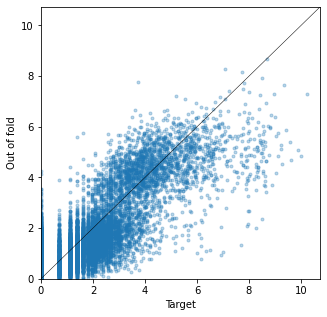

In [53]:
corr1 = train_y1.corr(pd.Series(oof_pred1))
print('corr1 =', corr1)
plot_scatter(train_y1, oof_pred1)

In [54]:
def plot_hist(oof, pred):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.histplot(pred, label='Test Predict', ax=ax, color='black')
    sns.histplot(oof, label='Out of fold', ax=ax, color='C1')
    ax.legend()
    ax.grid()

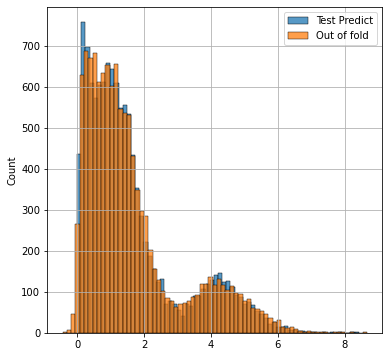

In [55]:
plot_hist(oof_pred1, np.log1p(df_test_pred))

In [56]:
print(f'- feat_cnt = {feat_cnt1}')
print(f'- score = {score1:.5f}')
print(f'- corr = {corr1:.5f}')

- feat_cnt = 96
- score = 1.02586
- corr = 0.81605


#### baseline_10: tuning
- feat_cnt = 96
- score = 1.02586
- corr = 0.81605

#### baseline_9-1: TE n_split=5に戻す, testにしかいないprincipal_makerは別モデル
- feat_cnt = 96, 92
- score = 1.03494, 1.05633
- corr = 0.81246, 0.80358
- LB = 1.0732

#### baseline_8: TE n_split=100
- feat_cnt = 96
- score = 1.00019
- corr = 0.82619
- LB = 1.0166

#### baseline_7: TE_principal_maker, TE_principal_or_first_maker
- feat_cnt = 96
- score = 1.03494
- corr = 0.81246
- LB = 1.0083

#### baseline_6: StratifiedKFold(n_splits=5)
- feat_cnt = 94
- score = 1.04358
- corr = 0.80887
- LB = 1.0219

#### baseline_5: dimension, area, country
- feat_cnt = 94
- score = 1.04760
- corr = 0.80725
- LB = 1.0197

#### baseline_4: color_count, categorical_feature
- feat_cnt = 75
- score = 1.05437
- corr = 0.80446
- LB = 1.0223

#### baseline_3: main_color
- feat_cnt = 73
- score = 1.06423
- corr = 0.80027
- LB = 1.0363

#### baseline_2: material, object_collection, place, technique, person
- feat_cnt = 61
- score = 1.07486
- corr = 0.79573
- LB = 1.0525

#### baseline_1: size, string_length
- feat_cnt = 25
- score = 1.11432
- corr = 0.77827
- LB = 1.1037

#### baseline_0
- feat_cnt = 16
- score = 1.20651
- corr = 0.73332
- LB = 1.1827

In [35]:
def visualize_importance(models):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

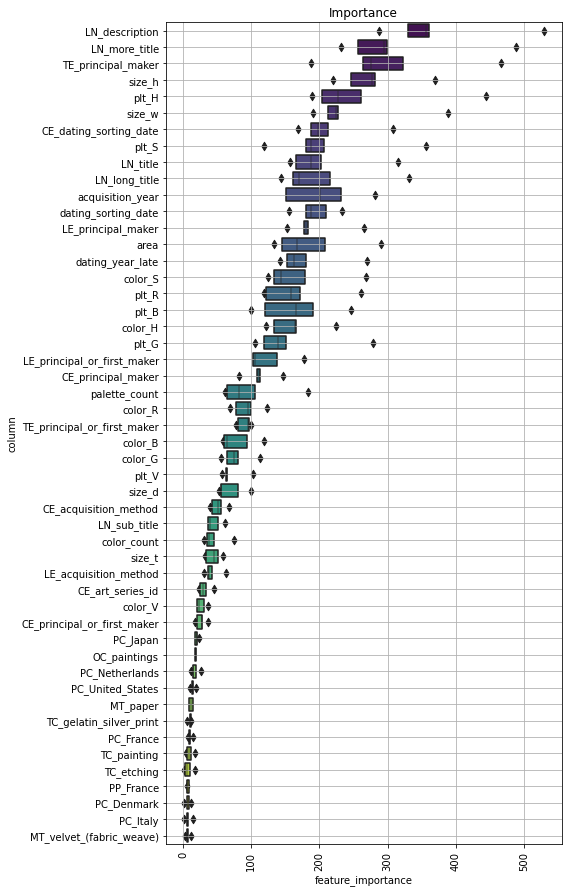

In [36]:
fig, ax = visualize_importance(models1)